In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold_slicing
import omnifold_routine
import PET
sys.path.append('.')
from my_utils import *

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="0" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-11-10 09:25:13.843763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 09:25:13.862013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762763113.877821 2612600 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762763113.882955 2612600 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762763113.897463 2612600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar_singletop_DR.pkl')
data_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_data.pkl')
data_df.fillna(0.0, inplace=True)


In [28]:
def DATA_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    
    return reco_features

pythia_train, pythia_test = subset(pythia_df, 2_000_000, train_test=True)
data_subset = subset(data_df, 2_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
data_array = DATA_shaper(data_subset)

In [29]:
data_array.shape

(2000000, 12, 4)

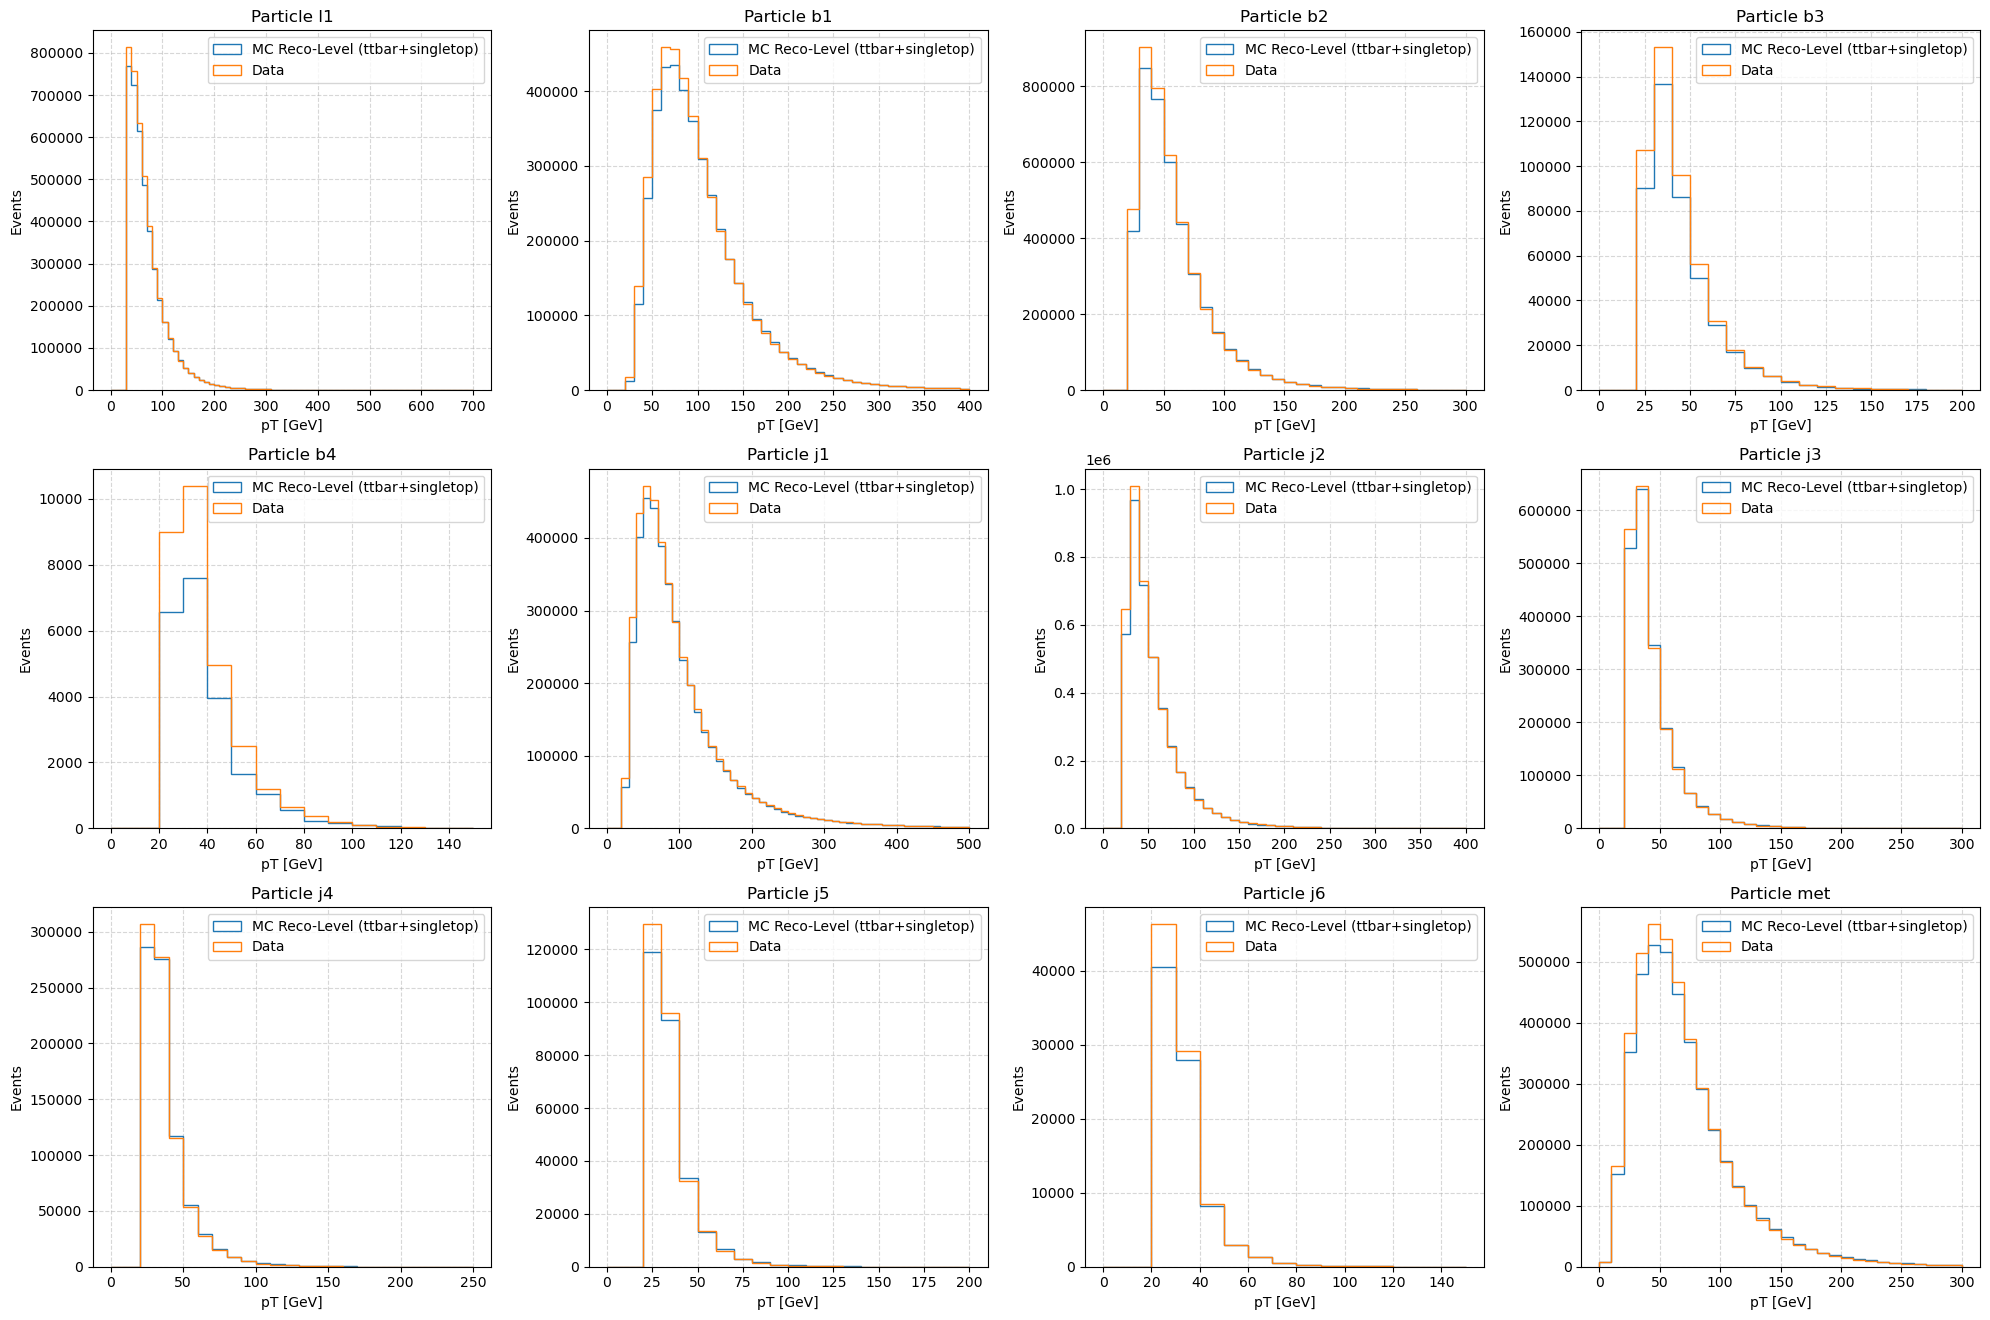

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']
pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    # masks for non-zero (non-padded) pT entries
    mask_pythia = pythia_reco_train[:, i, 0] != 0
    mask_data = data_array[:,i,0] != 0

    # Use .values[...] to align numpy masks with pandas Series
    ax.hist(
        pythia_reco_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_reco'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Reco-Level (ttbar+singletop)'
    )
    ax.hist(
        data_array[:, i, 0][mask_data],
        weights = data_subset['eventWeight'][mask_data],
        bins=bins,
        histtype='step',
        label='Data'
    )
    
    ax.set_title(f"Particle {pname}")
    ax.legend()
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.grid(True, linestyle='--', alpha=0.5)
    


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [31]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_data_scaled = jet_scaler.transform(data_array)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

In [32]:
data_loader = DataLoader(reco = X_data_scaled, weight = data_subset['eventWeight'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train['eventWeight'],
                           pass_reco = pythia_train['pass_reco'], pass_gen = pythia_train['pass_particle'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test['eventWeight'],
                           pass_reco = pythia_test['pass_reco'], pass_gen = pythia_test['pass_particle'], normalize=False)

INFO: Creating pass reco flag ...


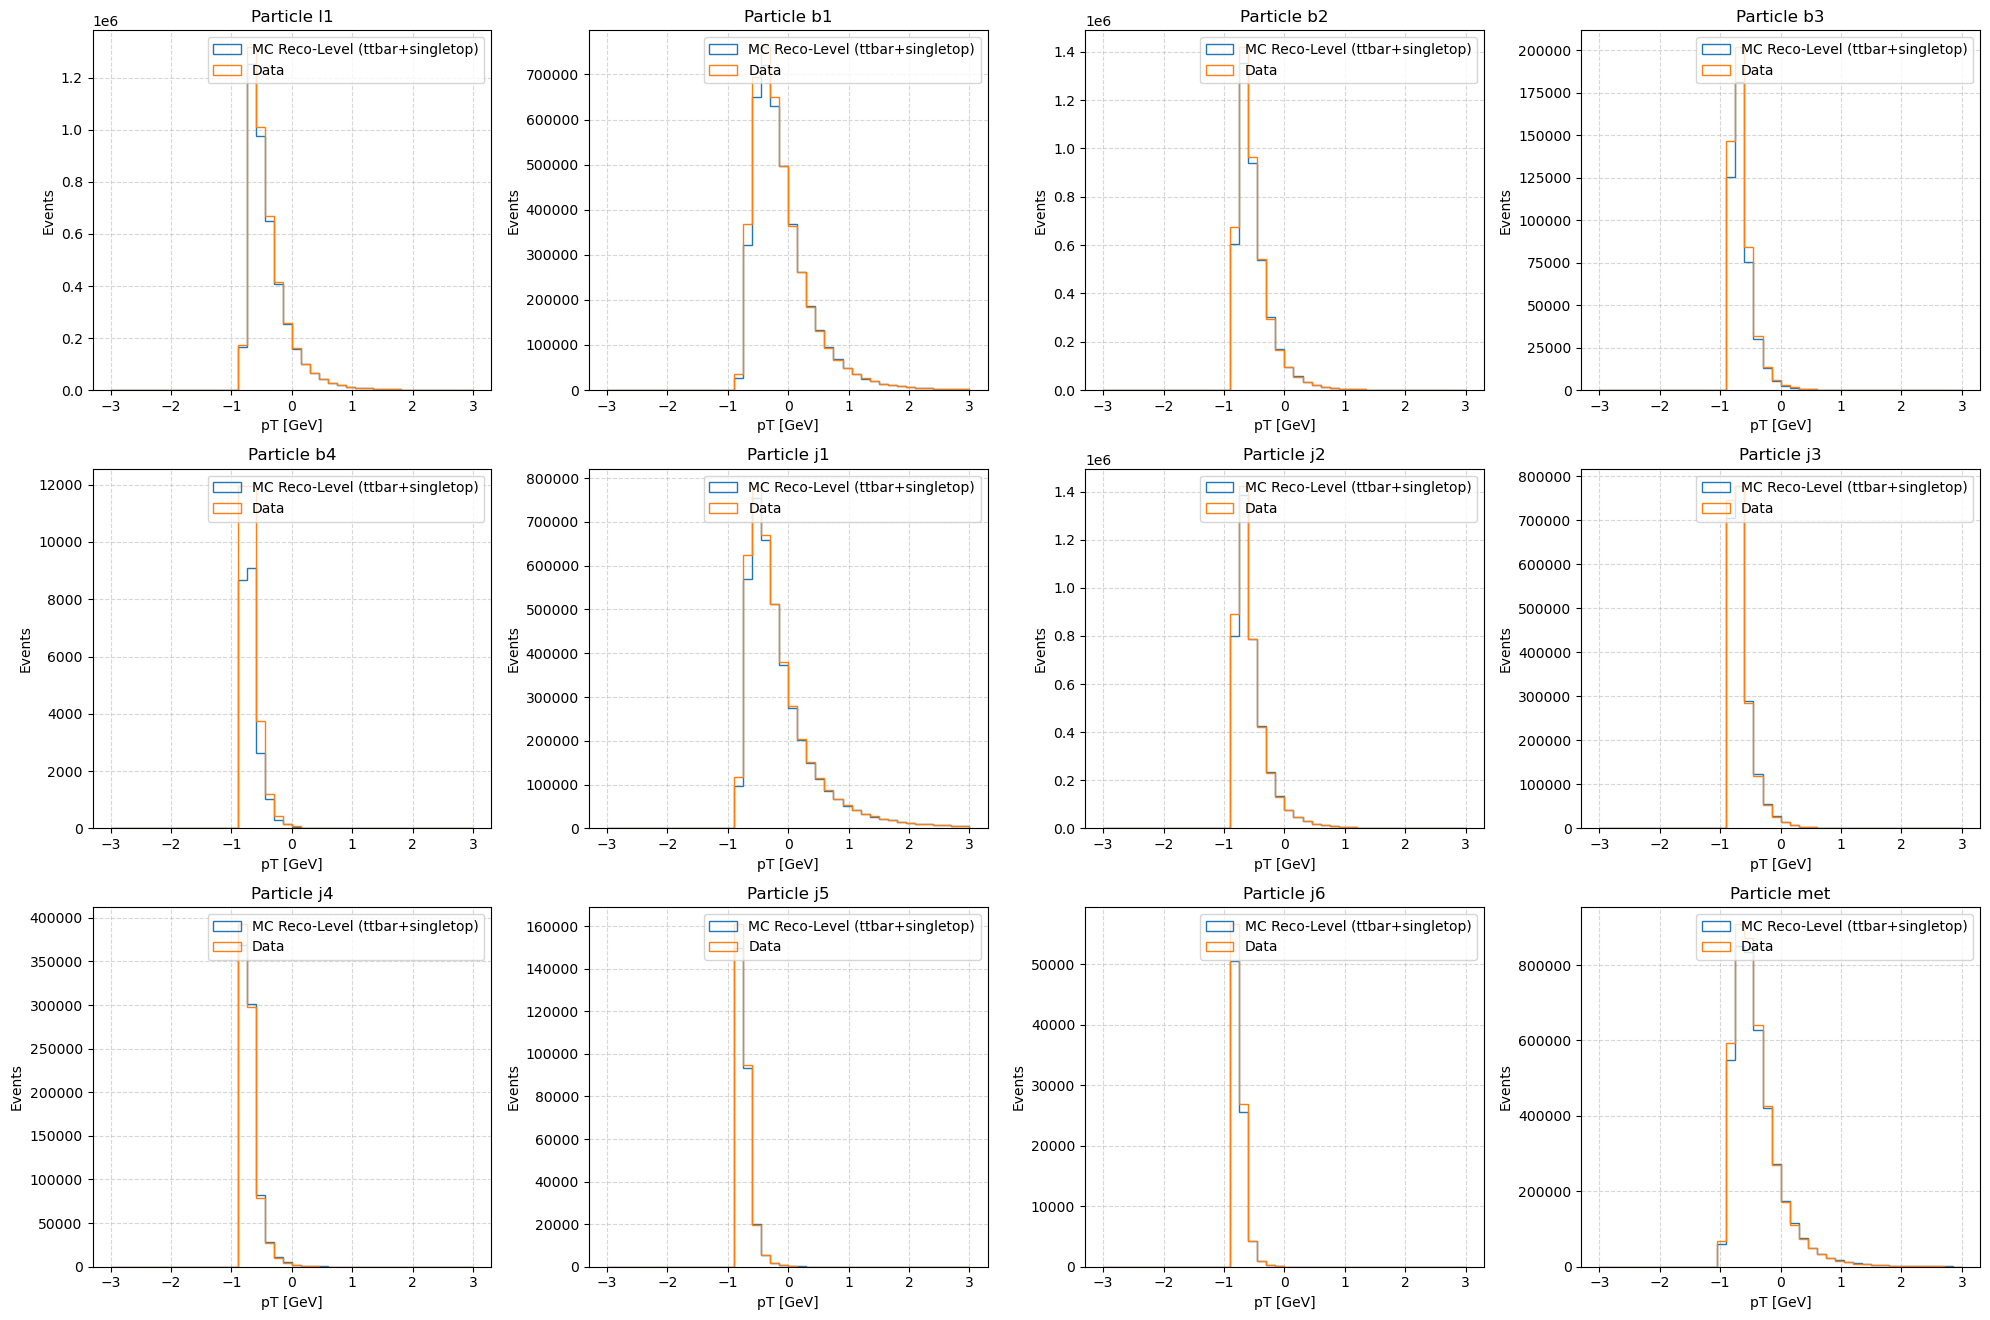

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

# --- Loop over all 12 particles ---
for i in range(len(particles)):
    ax = axes[i]
    
    # Plot pt distributions
    ax.hist(pythia_loader.reco[:, i, 0][pythia_loader.reco[:, i, 0]!=0], weights=(pythia_loader.weight*pythia_loader.pass_reco)[pythia_loader.reco[:, i, 0]!=0], bins=40, histtype='step', label='MC Reco-Level (ttbar+singletop)', range=[-3,3])
    ax.hist(data_loader.reco[:, i, 0][data_loader.reco[:, i, 0]!=0], weights=data_loader.weight[data_loader.reco[:, i, 0]!=0], bins=40, histtype='step', label='Data', range=[-3,3])
    
    ax.set_title(f"Particle {particles[i]}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [34]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 14 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=False)
model2 = PET.PET(num_feat = 4, num_part = 12, local=False)

I0000 00:00:1762771221.729589 2612600 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 136181 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:03:00.0, compute capability: 9.0


In [ ]:
omnifold_name = "pythiaWWbb_vs_real-data-5_iter-2M_evts_12"
weight_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_WWbbvsDATA'

omnifold = omnifold_routine.MultiFold(
    omnifold_name,
    model1, # model_reco
    model2, # model_gen
    data_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = weight_folder,
    verbose = True,
    early_stop=5,
    lr = 5e-6,
)

31250 training steps at reco and 31250 steps at gen


In [36]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 4000000, Test events used: 799999
################################################################################
Epoch 1/100


I0000 00:00:1762771441.595010 2781087 service.cc:152] XLA service 0x7f2bdc003ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762771441.595050 2781087 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-11-10 11:44:01.697432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762771442.366470 2781087 cuda_dnn.cc:529] Loaded cuDNN version 90501


   67/25000 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.3948 - loss: 1.4948    

I0000 00:00:1762771447.980227 2781087 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.4050 - loss: 1.4658 - val_accuracy: 0.4061 - val_loss: 1.4683 - learning_rate: 5.0000e-06
Epoch 2/100
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.4052 - loss: 1.4649 - val_accuracy: 0.4061 - val_loss: 1.4680 - learning_rate: 5.0000e-06
Epoch 3/100
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.4052 - loss: 1.4618 - val_accuracy: 0.4061 - val_loss: 1.4675 - learning_rate: 5.0000e-06
Epoch 4/100
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.4052 - loss: 1.4652 - val_accuracy: 0.4061 - val_loss: 1.4671 - learning_rate: 5.0000e-06
Epoch 5/100
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.4050 - loss: 1.4654 - val_accuracy: 0.4061 - val_loss: 1.4667 - learning_rate: 5.0000e-06
Epoch 6/100
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.4050 - loss: 1.4647 - val_accuracy: 0.4061 - val_loss: 1.4665 - learning_rate: 5.0000e-06
Epoch 7/100
25000/25000 ━━━━━━━━━━━━━━━━

In [37]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [38]:
np.save(f"{weight_folder}/{omnifold_name}_unfolded_weights.npy", unfolded_weights)

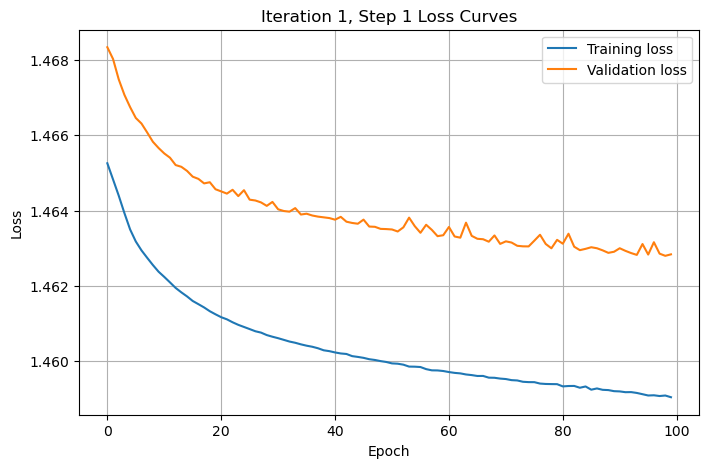

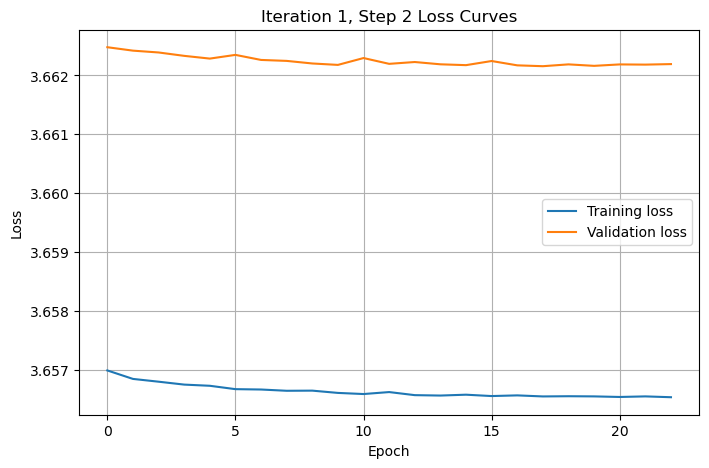

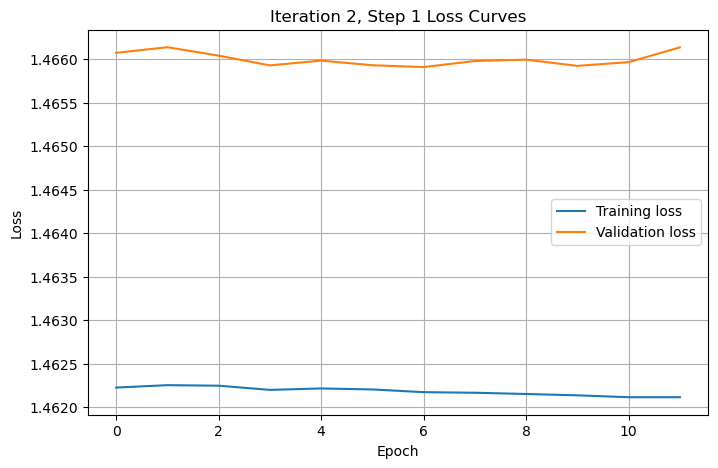

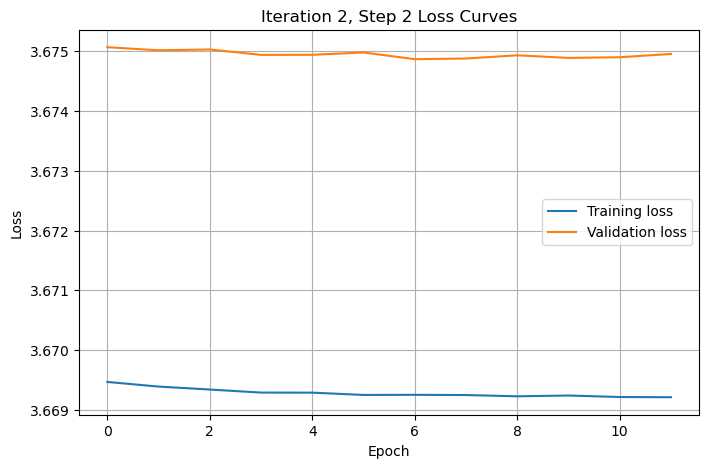

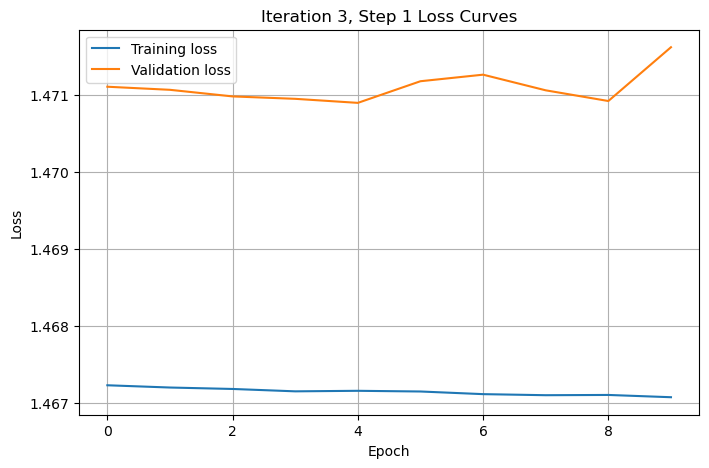

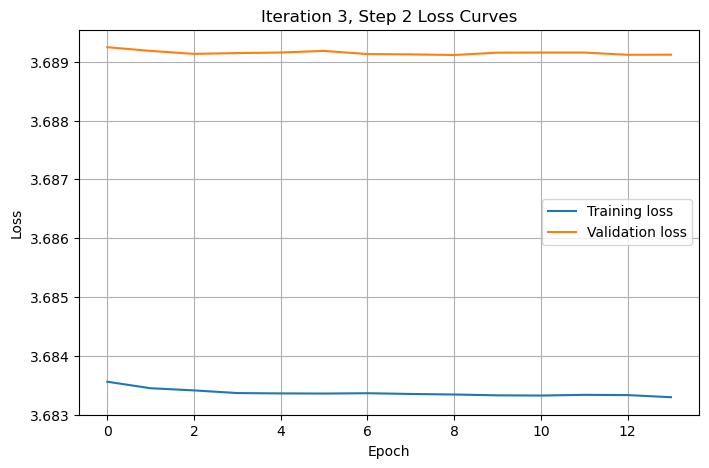

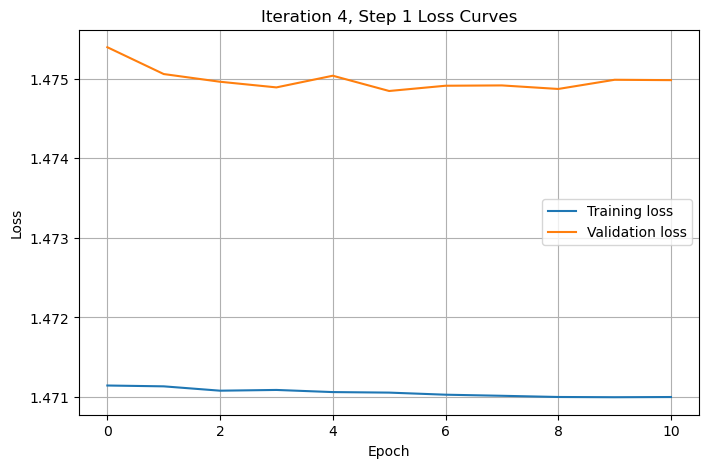

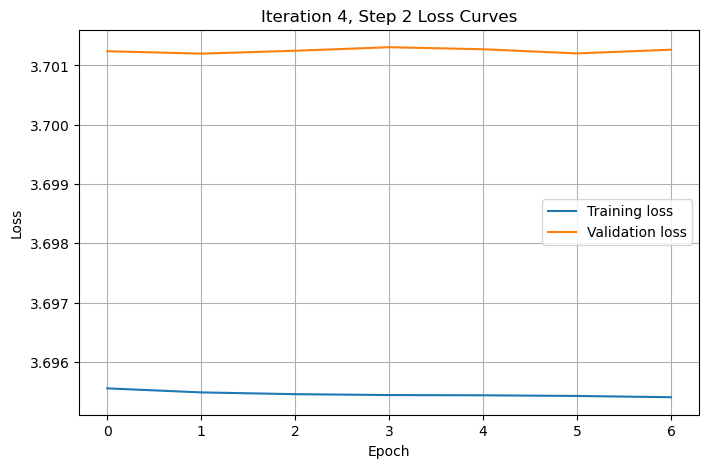

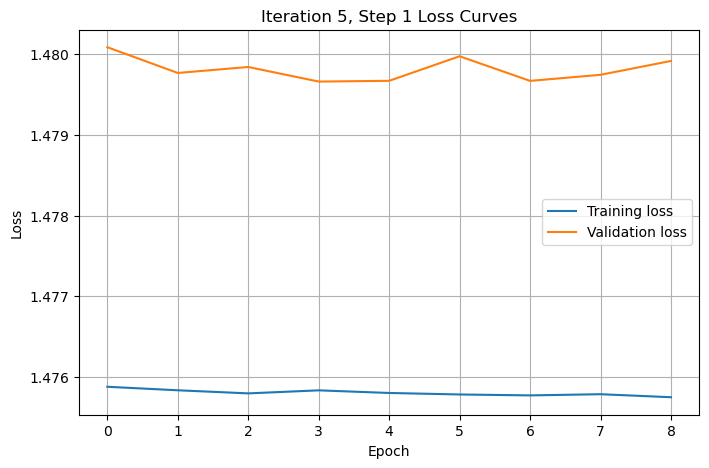

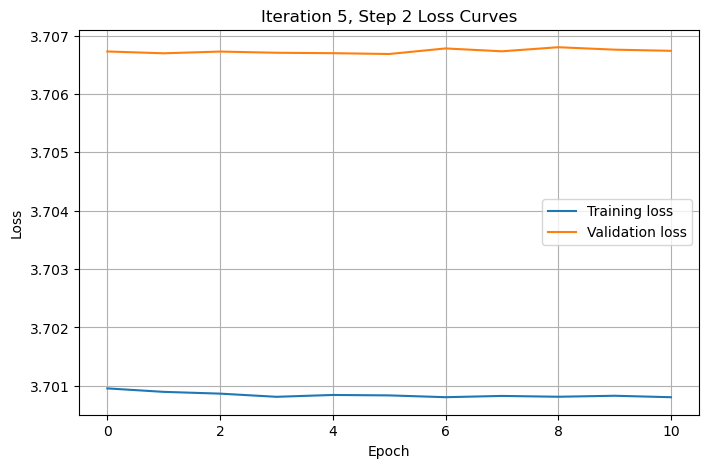

In [39]:
import pickle
# Set these to your parameters
weights_folder = weight_folder      
niter = 5                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()

In [44]:
def make_mc_subsample(loader, reco_cuts_mask, N_data):
    """
    Erzeuge ein MC-Subsample mit gleicher statistischer Genauigkeit wie die Daten.

    Parameters
    ----------
    loader : DataLoader
        DataLoader-Objekt mit Attributen `.reco`, `.gen`, `.weight`
    reco_cuts_mask : np.ndarray(bool)
        Maske der Events, die die Reco-Level-Cuts bestehen (analog zu den Daten)
    N_data : int
        Anzahl an Daten-Events, die die Reco-Level-Cuts bestehen
    """

    # Gesamtanzahl an MC-Events
    n_events = len(loader.weight)

    # Init: alle Flags auf False
    flags = np.zeros(n_events, dtype=bool)

    # Summen
    sum_w = 0.0
    sum_w2 = 0.0

    # Ziel-Statistik (Daten haben alle w=1)
    target_rel_unc = 1.0 / np.sqrt(N_data)

    # Loop über Events
    for idx in range(n_events):
        if not reco_cuts_mask[idx]:
            continue

        w = loader.weight.to_numpy()[idx]
        sum_w += w
        sum_w2 += w**2

        flags[idx] = True  # Event geht ins Subsample

        # relative Unsicherheit bisher
        rel_unc = np.sqrt(sum_w2) / sum_w

        if rel_unc < target_rel_unc:
            break

    return flags

flags_mc = make_mc_subsample(
    pythia_loader,
    reco_cuts_mask=pythia_loader.pass_reco,
    N_data=np.sum(data_loader.weight)
)

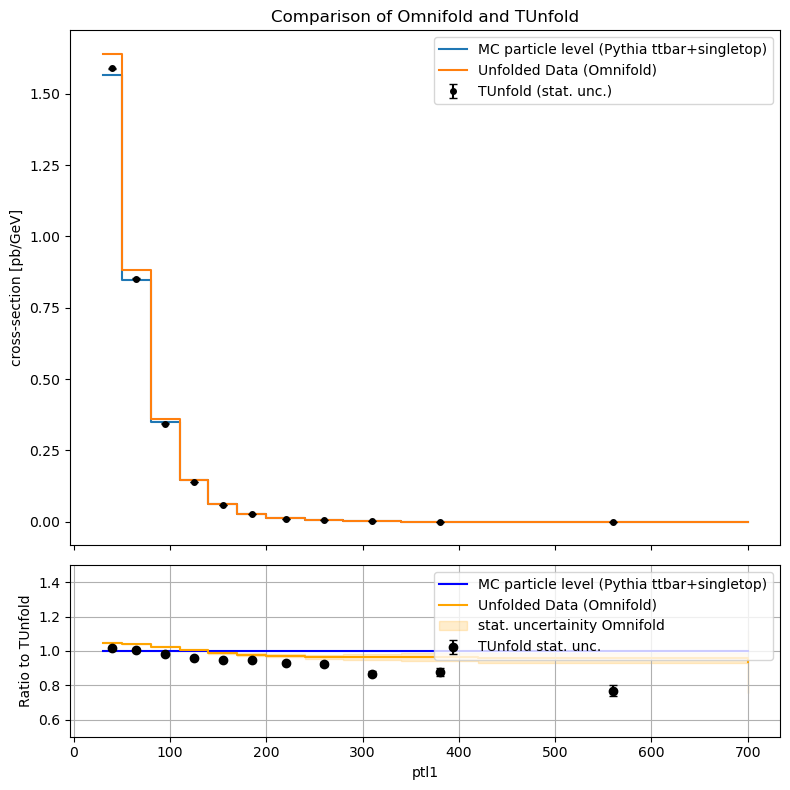

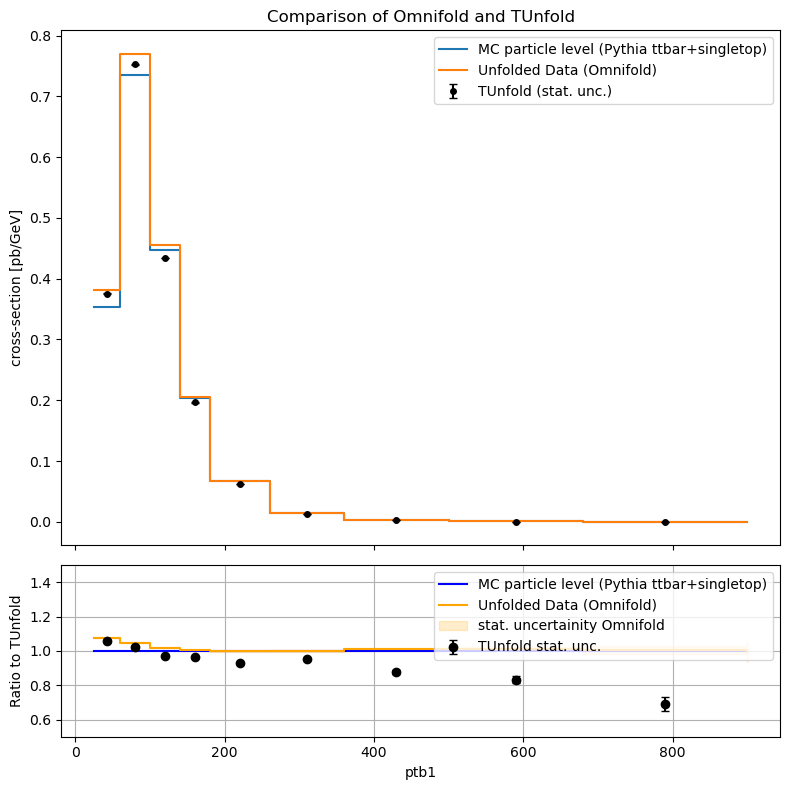

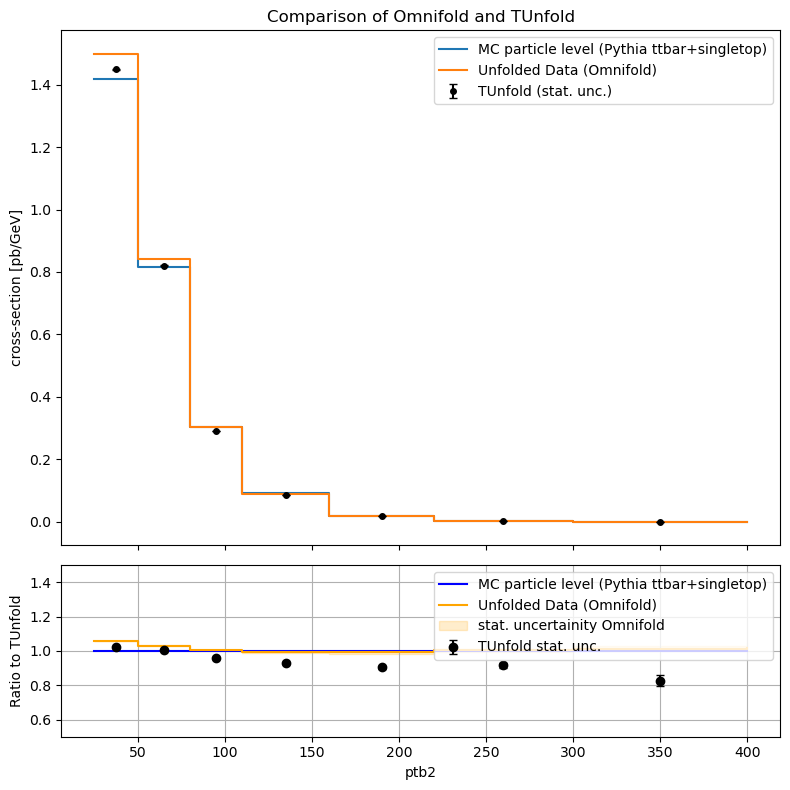

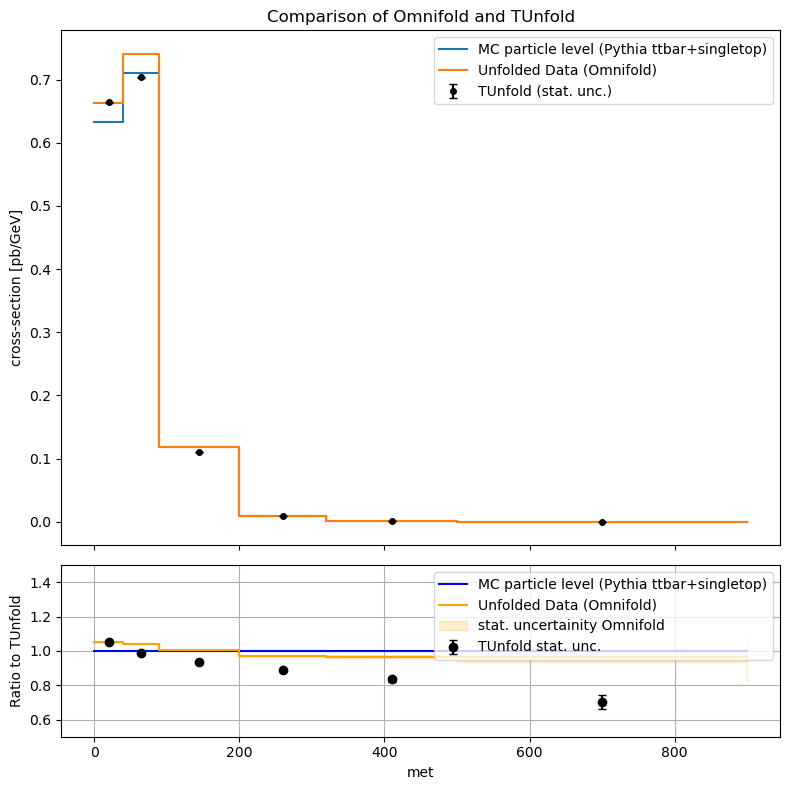

In [49]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)

# -------------------------------
# Loop over all observables
# -------------------------------
observables = {
    "ptl1": 0,  # lepton pt
    "ptb1": 1,
    "ptb2": 2,
    #"ptb3": 3,
    #"ptb4": 4,
    #"ptj1": 5,
    #"ptj2": 6,
    #"ptj3": 7,
    #"ptj4": 8,
    #"ptj5": 9,
    #"ptj6": 10,
    "met":  11,
}
for obs_name, obs_index in observables.items():

    hist = TUnfold_incl_file[f'unfolding_{obs_name}_NOSYS']
    rel_pt_up = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1up;1']
    rel_pt_down = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1down;1']
    values = hist.values()
    edges = hist.axis().edges()
    bin_widths = np.diff(edges)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    rel_unc_up_tunfold = rel_pt_up.values()
    rel_unc_down_tunfold = rel_pt_down.values()

    weights_omnifold = (unfolded_weights * pythia_test['eventWeight']*pythia_test["pass_particle"].to_numpy()) * SF
    weights_omnifold2 = weights_omnifold**2
    values_omnifold = pythia_truth_test[:, obs_index, 0]

    # Histogram Omnifold
    counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
    counts2_density = counts2 / bin_widths

    # relative Unsicherheit pro Bin für Omnifold
    sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
    counts2 = counts2.astype(float)
    sum_w2 = sum_w2.astype(float)

    with np.errstate(divide='ignore', invalid='ignore'):
        rel_unc_omnifold = np.sqrt(sum_w2) / counts2
        rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

    fig, (ax1, ax2) = plt.subplots(
        2, 1, 
        figsize=(8, 8), 
        gridspec_kw={'height_ratios': [3, 1]}, 
        sharex=True
    )

    # --- Upper panel: your histograms ---
    counts1, bins1, _ = ax1.hist(
        pythia_truth_test[:, obs_index, 0], 
        weights=pythia_test['eventWeight']*pythia_test["pass_particle"].to_numpy()*SF, 
        bins=edges, 
        histtype='step', 
        label='MC particle level (Pythia ttbar+singletop)'
    )
    counts2, bins2, _ = ax1.hist(
        values_omnifold, 
        weights=weights_omnifold, 
        bins=edges,   
        histtype='step', 
        label='Unfolded Data (Omnifold)'
    )
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # Normalize counts by bin width
    counts1_density = counts1 / bin_widths
    counts2_density = counts2 / bin_widths
    values_density = values / bin_widths
    abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
    abs_unc_down_tunfold = rel_unc_down_tunfold * values_density

    # Re-plot them stepwise
    ax1.cla()
    ax1.step(edges[:-1], counts1_density, where="post", label='MC particle level (Pythia ttbar+singletop)')
    ax1.step(edges[:-1], counts2_density, where="post", label='Unfolded Data (Omnifold)')
    yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
    ax1.errorbar(
        bin_centers[:-1], values_density[:-1],
        yerr=yerr[:,:-1],
        fmt='o', color='black', capsize=3, markersize=4,
        label="TUnfold (stat. unc.)"
    )
    #ax1.plot(bin_centers, values_density, 'o', color='black', label='TUnfold')

    ax1.set_ylabel("cross-section [pb/GeV]")
    ax1.set_title("Comparison of Omnifold and TUnfold")
    #ax1.set_yscale('log')
    ax1.legend()

    # --- Lower panel: ratio ---
    # Avoid division by zero
    ratio1 = np.divide(values_density, counts1_density, out=np.zeros_like(values_density), where=counts1_density!=0)
    ratio2 = np.divide(counts2_density, counts1_density, out=np.zeros_like(counts2_density), where=counts1_density!=0)
    ratio3 = np.ones_like(counts1_density)  # TUnfold / TUnfold

    # Step style ratios
    ratio1_step = np.append(ratio1, ratio1[-1])
    ratio2_step = np.append(ratio2, ratio2[-1])
    ratio3_step = np.append(ratio3, ratio3[-1])

    upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
    lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

    upper_tunfold = ratio1 * (1 + rel_unc_up_tunfold)
    lower_tunfold = ratio1 * (1 - rel_unc_down_tunfold)

    err_up_tunfold = ratio1 * rel_pt_up.values()
    err_down_tunfold = ratio1 * rel_pt_down.values()
    yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))

    ax2.step(edges[:-1], ratio3_step[:-1], where="post", color="blue", label='MC particle level (Pythia ttbar+singletop)')
    ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label='Unfolded Data (Omnifold)')
    ax2.errorbar(
        bin_centers[:-1], ratio1[:-1],
        yerr=yerr_tunfold[:,:-1],
        fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
    )
    ax2.fill_between(
        edges[:-1],
        lower_omnifold,
        upper_omnifold,
        step='post',
        alpha=0.2,
        color='orange',
        label='stat. uncertainity Omnifold'
    )

    ax2.set_xlabel(obs_name)
    ax2.set_ylabel("Ratio to TUnfold")
    ax2.set_ylim(0.5, 1.5)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

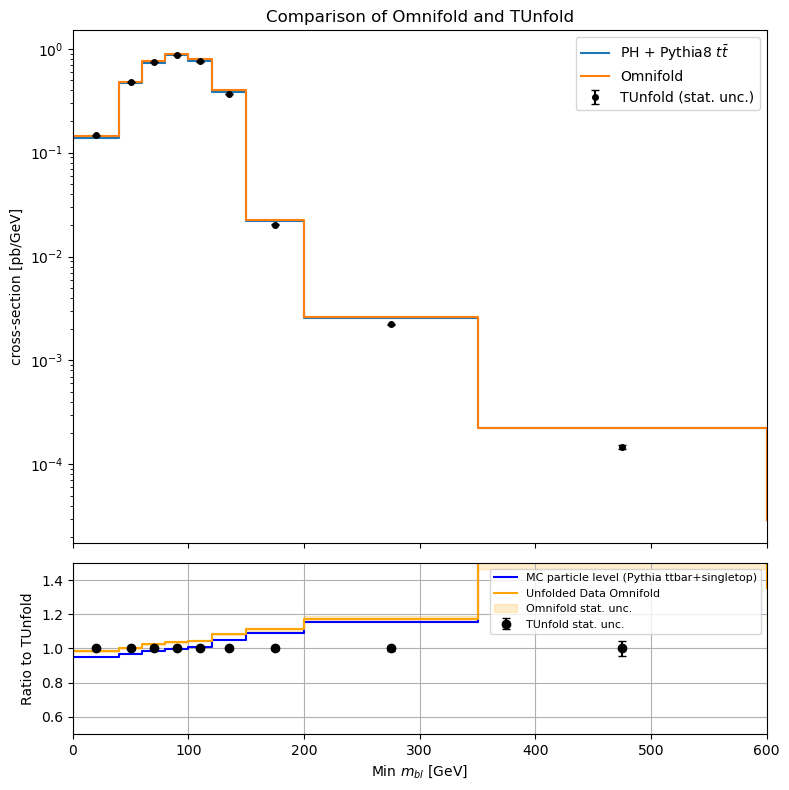

In [54]:
hist = TUnfold_incl_file['unfolding_mblmin_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_mblmin_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_mblmin_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * pythia_test['eventWeight']*pythia_test["pass_particle"].to_numpy()) * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = min_mbl(pythia_truth_test)
# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)



# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    min_mbl(pythia_truth_test), 
    weights=pythia_test['eventWeight']*pythia_test["pass_particle"].to_numpy()*SF, 
    bins=edges, 
    histtype='step', 
    label='MC particle level (Pythia ttbar+singletop)'
)
counts2, bins2, _ = ax1.hist(
    values_omnifold, 
    weights=weights_omnifold, 
    bins=edges,   
    histtype='step', 
    label='Unfolded Data (Omnifold)'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label='MC particle level (Pythia ttbar+singletop)')
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Unfolded Data Omnifold")
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)

ax2.set_xlabel(r"Min $m_{bl}$ [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(0, 600)
ax2.set_ylim(0.5, 1.5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [12]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1760596527.342044 3931412 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140838 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [17]:
importlib.reload(omnifold)

Horovod not found, will continue with single only GPUs.


<module 'omnifold.omnifold' from '/scratch/mjosef/Unfolding/omnifold/omnifold/omnifold.py'>

In [23]:
omnifold = omnifold.MultiFold(
    "WWbb_transformer_real-data",
    model1,
    model2,
    data_loader,
    pythia_loader,
    batch_size = 128,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data',
    verbose = True,
    lr = 5e-6,
    early_stop=5,
    n_ensemble=1,
)

15625 training steps at reco and 15625 steps at gen


In [24]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 1103700, Test events used: 275926
################################################################################
Epoch 1/100


I0000 00:00:1760596815.611433 3933599 service.cc:152] XLA service 0x55bd4c572c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760596815.611483 3933599 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-10-16 08:40:15.771842: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760596816.565081 3933599 cuda_dnn.cc:529] Loaded cuDNN version 90501


  84/6898 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.3997 

I0000 00:00:1760596823.892761 3933599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6898/6898 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.3533 - val_loss: 0.2823 - learning_rate: 5.0000e-06
Epoch 2/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2745 - val_loss: 0.2573 - learning_rate: 5.0000e-06
Epoch 3/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2545 - val_loss: 0.2496 - learning_rate: 5.0000e-06
Epoch 4/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.2485 - val_loss: 0.2477 - learning_rate: 5.0000e-06
Epoch 5/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2469 - val_loss: 0.2473 - learning_rate: 5.0000e-06
Epoch 6/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2470 - val_loss: 0.2473 - learning_rate: 5.0000e-06
Epoch 7/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2468 - val_loss: 0.2473 - learning_rate: 5.0000e-06
Epoch 8/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2468 - val_loss: 0.2473 - learning_rate: 5.0000e-06
Epoch 9/100
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.24

In [56]:
unfolded_weights  = omnifold.reweight(testset_loader.gen,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step


In [57]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_real-data/unfolded_weights_1M.npy", unfolded_weights)

In [12]:
unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_real-data/unfolded_weights_3M.npy")

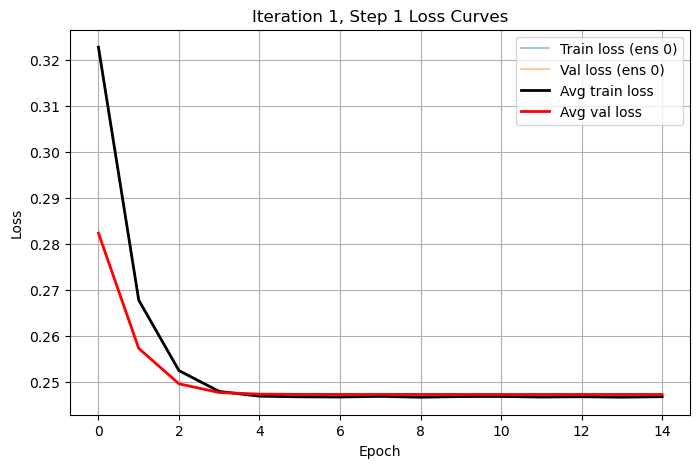

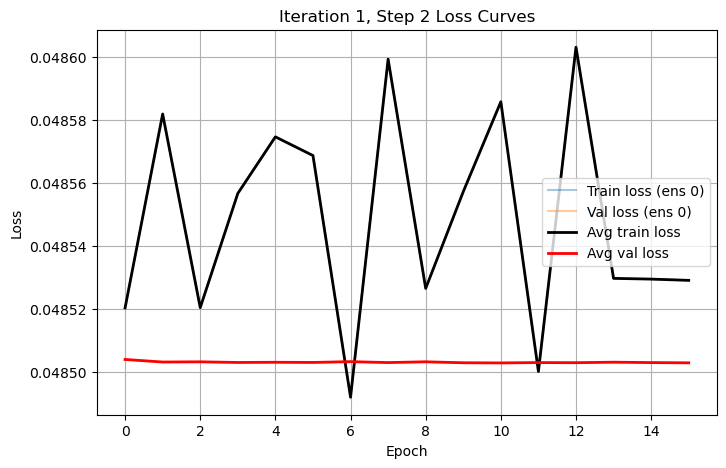

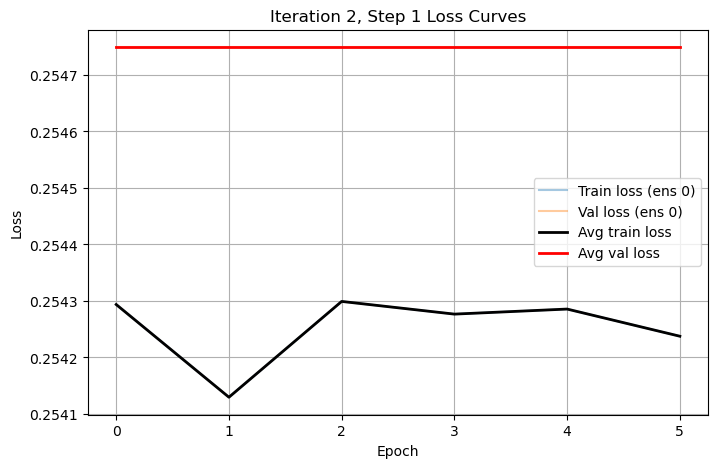

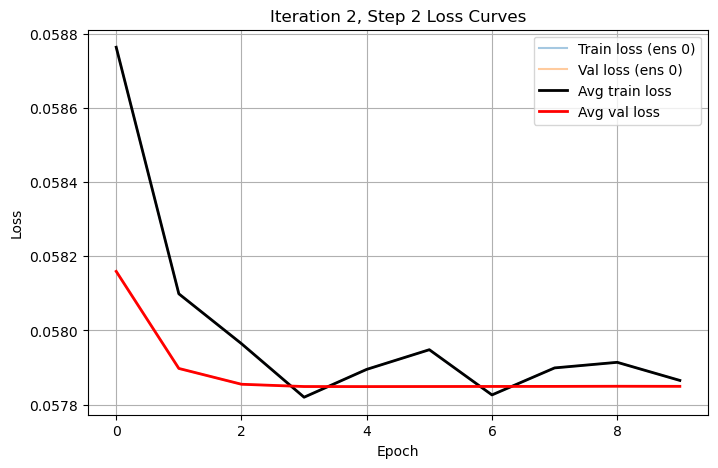

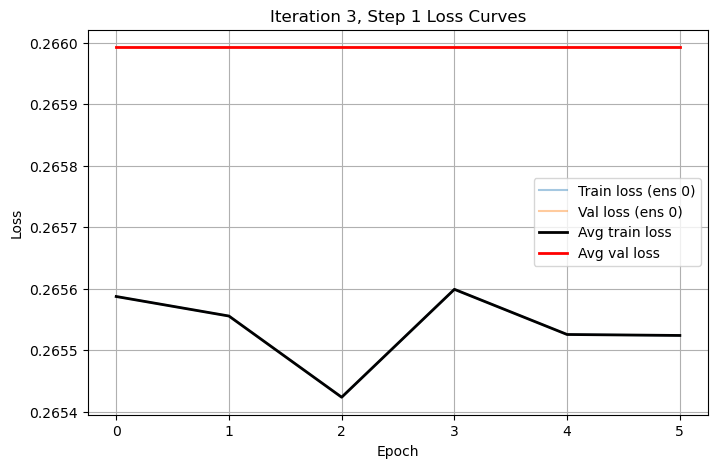

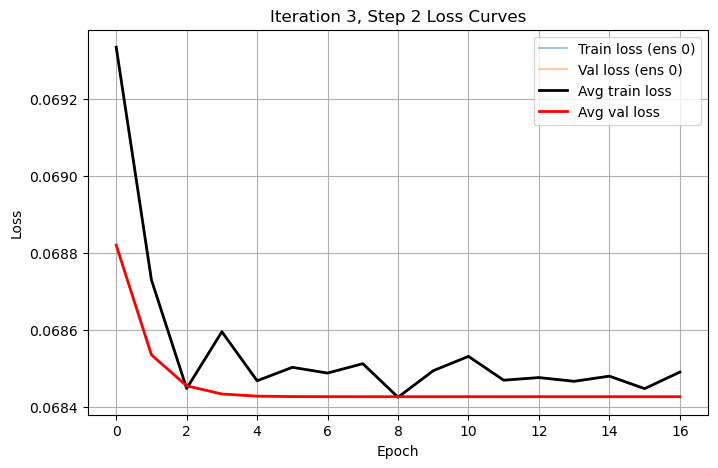

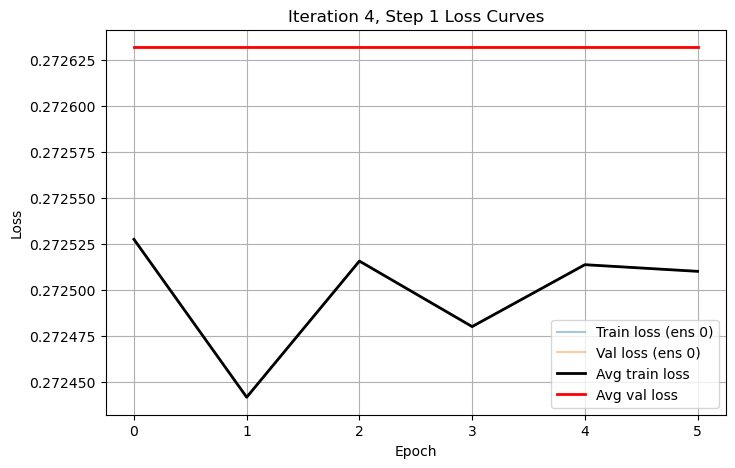

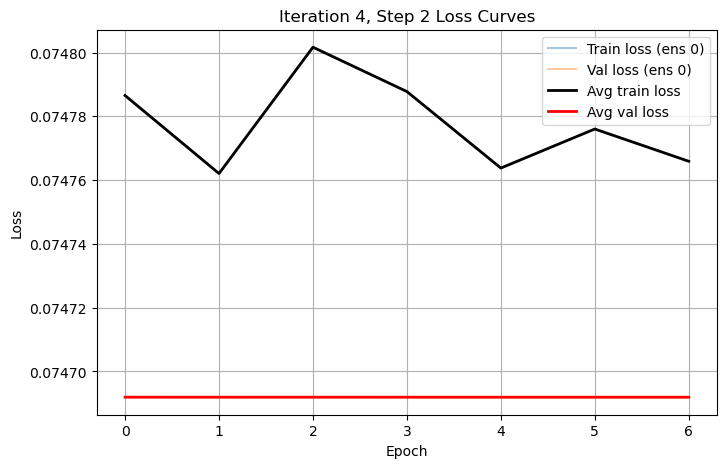

In [27]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data'       
name = "WWbb_transformer_real-data"      
niter = 4                   
n_ensemble = 1                   

for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}.weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
                
                # plot this ensemble individually
                plt.plot(history['loss'], alpha=0.4, label=f"Train loss (ens {e})")
                plt.plot(history['val_loss'], alpha=0.4, label=f"Val loss (ens {e})")
            else:
                print(f"History file not found: {history_file}")

        # ---- Optionally average (truncate to shortest) ----
        if all_loss:
            min_len = min(len(l) for l in all_loss)
            all_loss = [l[:min_len] for l in all_loss]
            all_val_loss = [l[:min_len] for l in all_val_loss]
            
            avg_loss = np.mean(all_loss, axis=0)
            avg_val_loss = np.mean(all_val_loss, axis=0)

            plt.plot(avg_loss, color='black', lw=2, label="Avg train loss")
            plt.plot(avg_val_loss, color='red', lw=2, label="Avg val loss")

        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_ptl1_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_ptl1_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * pythia_weights_test)[pythia_pass_gen_test & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = pythia_truth_test[:,0,0][pythia_pass_gen_test & flags_mc]

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)



# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    pythia_loader.gen[:,0,0][pythia_loader.pass_gen], 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    pythia_truth_test[:, 0, 0][pythia_pass_gen_test], 
    weights=(unfolded_weights * pythia_weights_test)[pythia_pass_gen_test] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)
#ax1.plot(bin_centers[:-1], values_density[:-1], 'o', color='black', label='TUnfold')

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Pythia8 $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Omnifold / TUnfold")
#ax2.plot(bin_centers[:-1], ratio3[:-1], 'o', color='black', label='TUnfold')
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
#ax2.fill_between(edges[:-1], lower_tunfold, upper_tunfold, step='post', alpha=0.3, color='grey', label='TUnfold stat. unc.')
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)
#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Lepton-pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(30, 700)
ax2.set_ylim(0.5, 1.5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()

ValueError: weights should have the same shape as a.

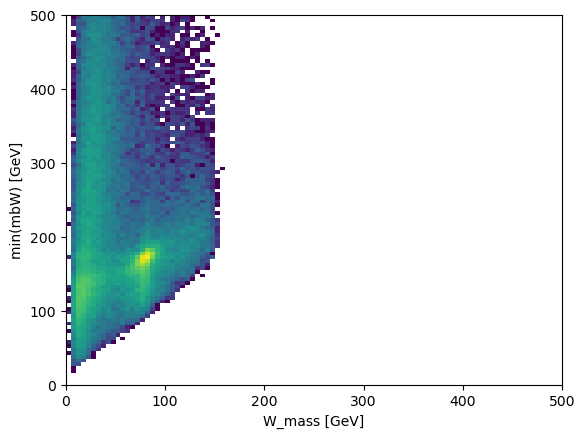

In [19]:
plt.hist2d(calculate_mass(W_candidate((pythia_truth_test[pythia_pass_gen_test & flags_mc]))), min_mbW(pythia_truth_test[pythia_pass_gen_test & flags_mc]), bins=100, range=[[0,500],[0,500]], norm=LogNorm())
plt.xlabel("W_mass [GeV]")
plt.ylabel("min(mbW) [GeV]")
plt.show()

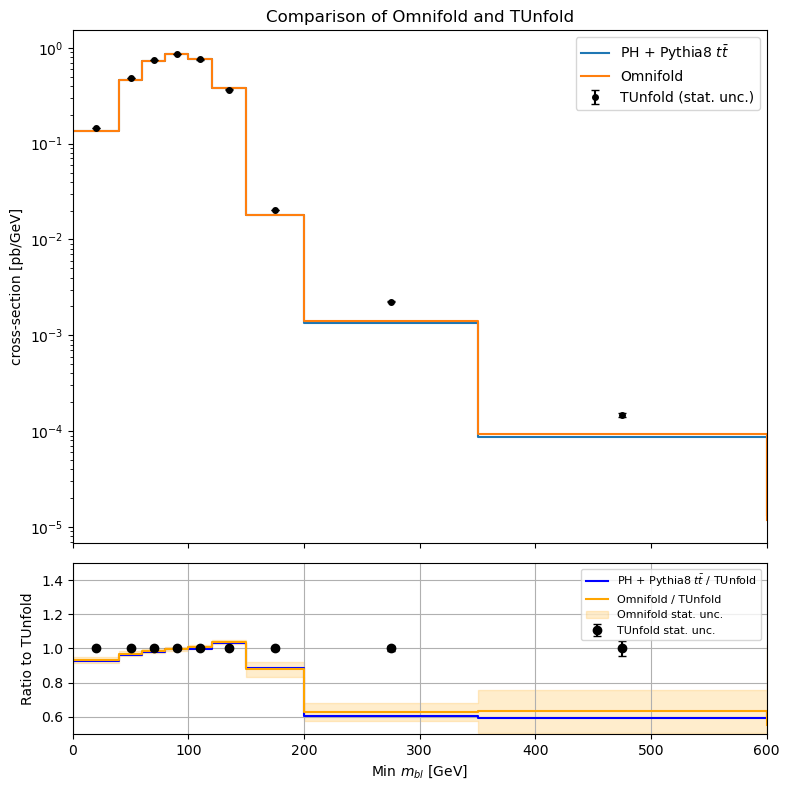

In [47]:
hist = TUnfold_incl_file['unfolding_mblmin_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_mblmin_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_mblmin_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * pythia_weights_test)[pythia_pass_gen_test & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = min_mbl(pythia_truth_test[pythia_pass_gen_test & flags_mc])

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)



# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    min_mbl(pythia_loader.gen[pythia_loader.pass_gen]), 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    min_mbl(pythia_truth_test[pythia_pass_gen_test]), 
    weights=(unfolded_weights * pythia_weights_test)[pythia_pass_gen_test] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Pythia8 $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Omnifold / TUnfold")
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)

ax2.set_xlabel(r"Min $m_{bl}$ [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(0, 600)
ax2.set_ylim(0.5, 1.5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()

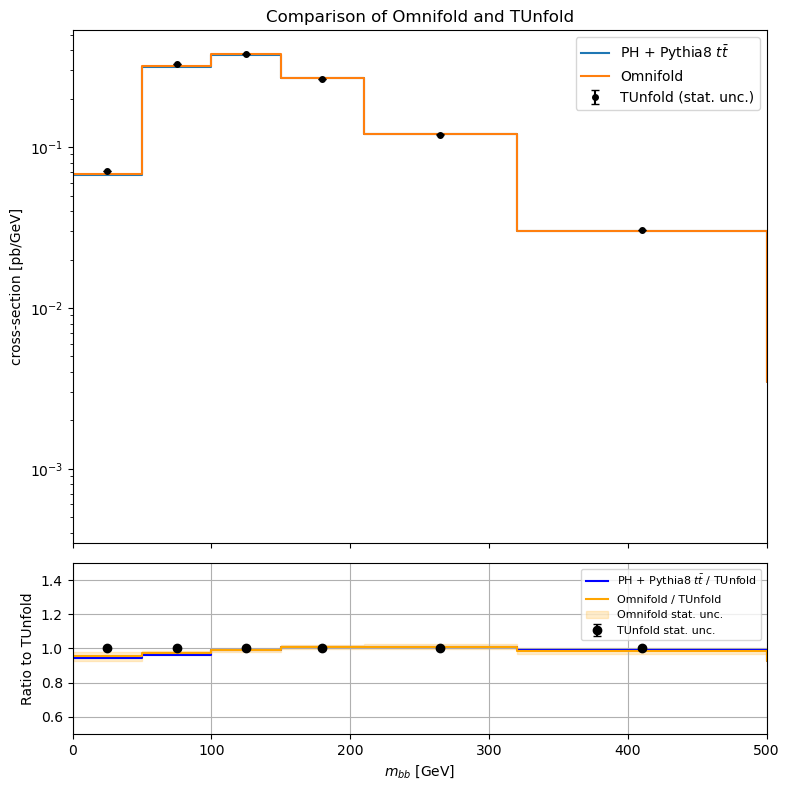

In [46]:
hist = TUnfold_incl_file['unfolding_mbb_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_mbb_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_mbb_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * pythia_weights_test)[pythia_pass_gen_test & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = mbb(pythia_truth_test[pythia_pass_gen_test & flags_mc])

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)



# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    mbb(pythia_loader.gen[pythia_loader.pass_gen]), 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    mbb(pythia_truth_test[pythia_pass_gen_test]), 
    weights=(unfolded_weights * pythia_weights_test)[pythia_pass_gen_test] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Pythia8 $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Omnifold / TUnfold")
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)

ax2.set_xlabel(r"$m_{bb}$ [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(0, 500)
ax2.set_ylim(0.5, 1.5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()

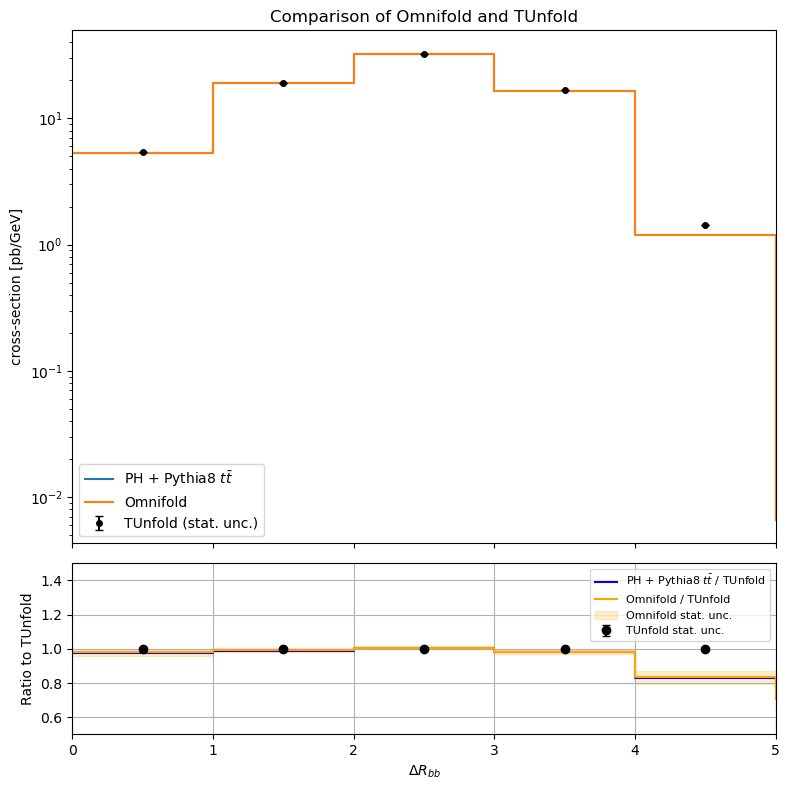

In [52]:
hist = TUnfold_incl_file['unfolding_dR2b_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_dR2b_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_dR2b_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * pythia_weights_test)[pythia_pass_gen_test & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = dR2b(pythia_truth_test[pythia_pass_gen_test & flags_mc])

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)



# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    dR2b(pythia_loader.gen[pythia_loader.pass_gen]), 
    weights=pythia_loader.weight[pythia_loader.pass_gen]*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    dR2b(pythia_truth_test[pythia_pass_gen_test]), 
    weights=(unfolded_weights * pythia_weights_test)[pythia_pass_gen_test] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Pythia8 $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Omnifold / TUnfold")
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)

ax2.set_xlabel(r"$\Delta R_{bb}$")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(0, 5)
ax2.set_ylim(0.5, 1.5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()